## Various imports and setting up

In [1]:
import os
import random
import re
import string
import matplotlib.pyplot as plt

import nltk
import numpy as np
import pandas as pd

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from statistics import mean
nltk.download("stopwords")

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
pre_df = pd.read_csv("data/preprocessed_df.csv")

In [3]:
# FUNCTIONS
def clean_text(text, tokenizer, stopwords): # return tokenized text

    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

def num_there(s):
    return any(i.isdigit() for i in s)
def remove_words(tokens, remove_words):
    return [i for i in tokens if i not in remove_words]
def remove_numbers(tokens):
    return [i for i in tokens if not num_there(i)]

colors = ["blue", "green", "red", "cyan", "magenta", "black", "yellow", "black", "white", "pink", "rose", "pinkblue", "purple", "redwhite", "gold", "chocolate", "polkadot", ""]
materials = ["zinc", "wood", "plastic", "iron", "crystal", "metal", "silver", "ceramic"]
others = ["3d", "small", "large", "medium", "set", "", "vintage", "design", "bundle", "retro", "kit"]
all_words = np.concatenate((colors, materials, others))

In [4]:
# TOKENIZING DOCS
import nltk
nltk.download('punkt')

# download stopwords
custom_stopwords = set(stopwords.words("english") + ["news", "new", "top"])

df = pre_df.copy()
df["Description"] = df["Description"].fillna("")

# cleaning the description with the function clean text
df["tokens"] = df["Description"].map(lambda x: clean_text(x, word_tokenize, custom_stopwords))

# Remove duplicated after preprocessing
_, idx = np.unique(df["Description"], return_index=True)
df = df.iloc[idx, :]

# Remove empty values and keep relevant columns
df = df.loc[df.tokens.map(lambda x: len(x) > 0), ["Description", "tokens"]]
docs = df["Description"].values

df["tokens"] = df["tokens"].apply(lambda x: remove_words(x, all_words))
df["tokens"] = df["tokens"].apply(lambda x: remove_numbers(x))

tokenized_docs = df["tokens"].values
print(f"Original dataframe: {pre_df.shape}")
print(f"Unique descriptions dataframe: {df.shape}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Original dataframe: (787490, 11)
Unique descriptions dataframe: (5147, 2)


## DOWNLOADING PRE-TRAINED MODEL

In [5]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

we will now vectorize with the pretrained model and create clusters

In [6]:
def vectorize(list_of_docs, model):
    features = []
    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in wv:
                try:
                    vectors.append(wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

## VECTORIZING DOCS WITH PRE-TRAINED MODEL

In [7]:
vectorized_docs = vectorize(tokenized_docs, model=wv)
len(vectorized_docs), len(vectorized_docs[0])

(5147, 300)

In [8]:
def calculate_scores_n_cluster(X, rang):
    silhouette_avg = []
    cost =[]
    for k in rang:
        KM = MiniBatchKMeans(n_clusters = k, max_iter = 500, batch_size = 4096)
        KM.fit(X)
        # calculates squared error for the clustered points
        cost.append(KM.inertia_)    
        silhouette_avg.append(silhouette_score(X, KM.labels_))
    return cost, silhouette_avg
    

## VISUALIZING SCORES FOR MANY K VALUES

### without PCA

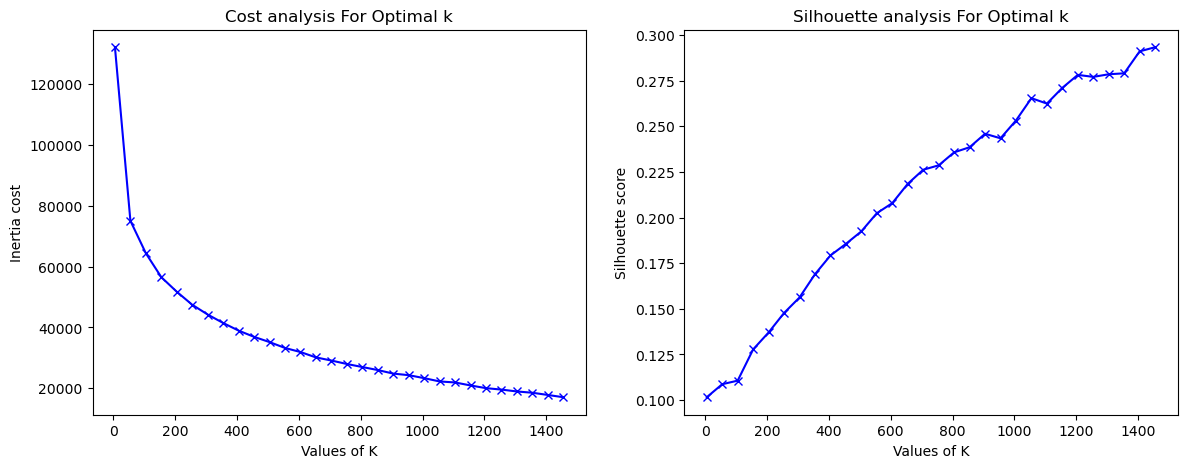

In [42]:
n_max = 1500
step = 50 
range_n_clusters = range(5, n_max, step)

figure, axis = plt.subplots(1, 2, figsize=(14, 5))

# calculate cost and silhouette avg without pca
cost, silhouette_avg = calculate_scores_n_cluster(X=vectorized_docs, rang=range_n_clusters)

# calculate cost and silhouette avg with cosine pca on similarity 
cosine_matrix = cosine_similarity(vectorized_docs)
pca = PCA(n_components=30, random_state=4)
pca_cosine_matrix = pca.fit_transform(cosine_matrix)
cost, silhouette_avg = calculate_scores_n_cluster(X=pca_cosine_matrix, rang=range_n_clusters)

# cost plot
axis[0].plot(range_n_clusters, cost,"bx-")
axis[0].set(xlabel='Values of K', ylabel='Inertia cost')
axis[0].set_title("Cost analysis For Optimal k")
# silhousette plot
axis[1].plot(range_n_clusters, silhouette_avg,"bx-")
axis[1].set(xlabel='Values of K', ylabel='Silhouette score')
axis[1].set_title("Silhouette analysis For Optimal k")
plt.savefig("data\cost_silh_analysis.png")

### With cosine similarity and PCA

## PCA visualization

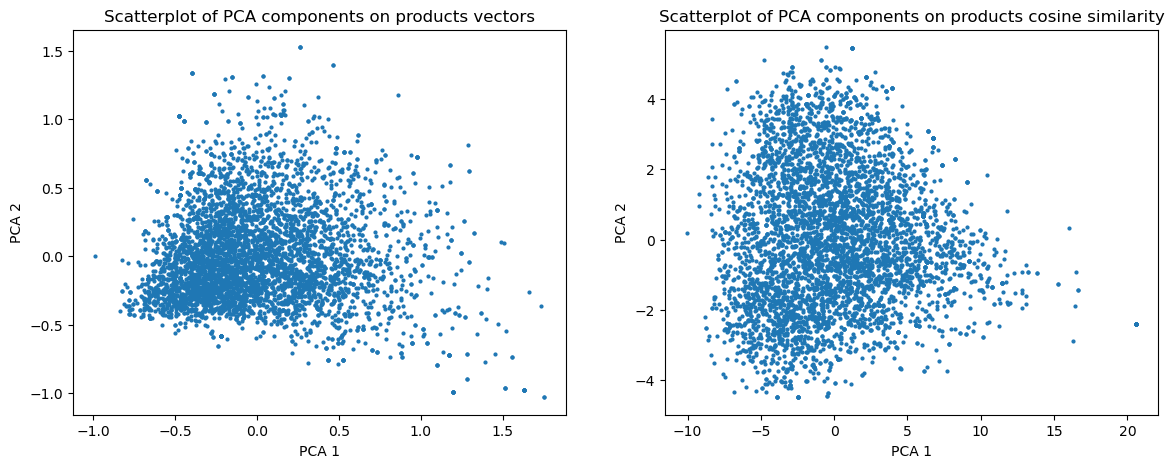

In [41]:
# reduce the cluster centers to 2D

pca = PCA(n_components=2, random_state=4)
cosine_matrix_pca = pca.fit_transform(cosine_matrix)

pca = PCA(n_components=2, random_state=4)
vectors_pca = pca.fit_transform(vectorized_docs)

cosine_matrix_pca_df = pd.DataFrame(cosine_matrix_pca, columns=["pca_1", "pca_2"])
vectors_pca_df = pd.DataFrame(vectors_pca, columns=["pca_1", "pca_2"])

figure, axis = plt.subplots(1, 2, figsize=(14, 5))

axis[0].scatter(vectors_pca_df["pca_1"], vectors_pca_df["pca_2"],  s=4)
axis[0].set(xlabel='PCA 1', ylabel='PCA 2')
axis[0].set_title("Scatterplot of PCA components on products vectors")

axis[1].scatter(cosine_matrix_pca_df["pca_1"], cosine_matrix_pca_df["pca_2"],  s=4)
axis[1].set(xlabel='PCA 1', ylabel='PCA 2')
axis[1].set_title("Scatterplot of PCA components on products cosine similarity")
plt.savefig("data\pca_components_product.png")

## CATEGORY CLUSTERING WITH COSINE SIMILARITY

In [28]:
cosine_matrix

n_cluster = 500
print_most_representative = True
pca = PCA(50)
pca_cosine_matrix = pca.fit_transform(cosine_matrix)

clustering = MiniBatchKMeans(n_clusters=n_cluster, batch_size=4096 ).fit(pca_cosine_matrix)
cluster_labels = clustering.labels_
df_clusters = pd.DataFrame({"text": docs, "tokens": [" ".join(text) for text in tokenized_docs],"cluster": cluster_labels})



## MERGING WITH THE INITIAL DF

In [15]:
# adding pca values from vector as additional features
pca = PCA(n_components=30, random_state=4)
reduced_features = pca.fit_transform(vectorized_docs)
clusters_pca_df = pd.concat((df_clusters, pd.DataFrame(reduced_features, columns=[f"pca_{i+1}" for i in range(30)])), axis=1)

# merging pca values with scalar values
vector_scalars_df = pd.DataFrame(vectorized_docs, columns=[f"scalar_{i+1}" for i in range(300)])
clusters_pca_scalars_df = pd.concat([clusters_pca_df, vector_scalars_df], axis=1)

## MERGING WITH THE INITIAL DF

In [16]:
# merging with the initial dataset
complete_df = pre_df.merge(clusters_pca_scalars_df, how='left', left_on="Description", right_on="text")
complete_df = complete_df.drop(['text', 'tokens'], axis=1)
complete_df = pd.get_dummies(complete_df, columns=['cluster'])

In [17]:
def keep_with_word(lst, word):
    new_lst = []
    for string in lst:
        if word in string:
            new_lst.append(string)
    return new_lst

## GROUPING BY CUSTOMER

In [18]:
# getting columns names to aggregate
columns_list = complete_df.columns.values.tolist() 

comprend_pca = True
cluster_columns = keep_with_word(columns_list, "cluster")
scalar_columns = keep_with_word(columns_list, "scalar")
if comprend_pca:
    pca_columns = keep_with_word(columns_list, "pca")

clusters_dict = [{cluster:"sum"} for cluster in cluster_columns]
scalars_dict = [{scalar:["mean", "max", "min"]} for scalar in scalar_columns]
if comprend_pca:
    pca_dict = [{pca:["mean", "max", "min"]} for pca in pca_columns]

all_dicts = {}
for d in clusters_dict:
    all_dicts.update(d)
    
for d in scalars_dict:
    all_dicts.update(d)
if comprend_pca: 
    for d in pca_dict:
        all_dicts.update(d)
    
    
grouped_df = complete_df.groupby(['Customer ID']).agg(all_dicts)

In [43]:
grouped_df

cluster_0 cluster_1 cluster_2 cluster_3 cluster_4 cluster_5  \
                  sum       sum       sum       sum       sum       sum   
Customer ID                                                               
12346.0             0         0         0         0         0         0   
12347.0             0         0         0         0         0         1   
12348.0             0         0         0         0         0         0   
12349.0             0         1         0         0         0         0   
12350.0             0         0         0         0         1         0   
...               ...       ...       ...       ...       ...       ...   
18283.0             0         0         1         0         7         2   
18284.0             0         0         0         0         0         0   
18285.0             0         0         0         0         0         0   
18286.0             0         0         0         2         1         0   
18287.0             0         0         0         0         0         0   

            cluster_6 cluster_7 cluster_8 cluster_9  ...    pca_27    pca_28  \
                  sum       sum       sum       sum  ...       min      mean   
Customer ID                                          ...                       
12346.0             0         0         0         0  ... -0.432086 -0.213990   
12347.0             0         0         0         0  ... -0.425439  0.044953   
12348.0             0         0         0         0  ... -0.271562  0.007064   
12349.0             0         0         1         0  ... -0.623427 -0.042647   
12350.0             0         0         0         0  ... -0.356789  0.023963   
...               ...       ...       ...       ...  ...       ...       ...   
18283.0             8         0         0         0  ... -0.363766  0.021434   
18284.0             0         0         0         0  ... -0.279438  0.016564   
18285.0             0         0         0         0  ... -0.332254  0.004941   
18286.0             0         0         0         0  ... -0.360854 -0.051081   
18287.0             0         5         1         0  ... -0.293984 -0.009684   

                                   pca_29                        pca_30  \
                  max       min      mean       max       min      mean   
Customer ID                                                               
12346.0      0.180479 -0.606661  0.053444  0.271031 -0.186682  0.166667   
12347.0      0.410744 -0.374708  0.009251  0.401042 -0.427435 -0.044624   
12348.0      0.339127 -0.536181 -0.034232  0.224344 -0.223062  0.064581   
12349.0      0.375384 -0.709644 -0.014083  0.444531 -0.511875  0.042034   
12350.0      0.237251 -0.237317  0.047979  0.326207 -0.102195 -0.056542   
...               ...       ...       ...       ...       ...       ...   
18283.0      0.344988 -0.373458 -0.022504  0.481858 -0.427435 -0.049807   
18284.0      0.313231 -0.280245  0.032401  0.400207 -0.380549  0.006941   
18285.0      0.146293 -0.116229 -0.028741  0.178990 -0.352340 -0.032674   
18286.0      0.293603 -0.606661 -0.036341  0.316027 -0.514752 -0.045439   
18287.0      0.365904 -0.316074  0.018102  0.371574 -0.375725 -0.015993   

                                 
                  max       min  
Customer ID                      
12346.0      0.742804 -0.103894  
12347.0      0.297466 -0.358985  
12348.0      0.449545 -0.185161  
12349.0      0.838816 -0.345309  
12350.0      0.144633 -0.266191  
...               ...       ...  
18283.0      0.536423 -0.613575  
18284.0      0.297466 -0.503707  
18285.0      0.212058 -0.235998  
18286.0      0.269150 -0.361588  
18287.0      0.406906 -0.432197  

[5878 rows x 1490 columns]

## Saving the dataframe

In [32]:
grouped_df.to_csv("customer_clust.csv")